In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.densenet import preprocess_input

In [2]:
# Imports for image transformations
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np

X_train = np.load('/content/drive/MyDrive/Colab Notebooks/X_traindl_with_masks.npy')
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/y_traindl_with_masks.npy')

X_val = np.load('/content/drive/MyDrive/Colab Notebooks/X_valdl_with_masks.npy')
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/y_valdl_with_masks.npy')

X_test = np.load('/content/drive/MyDrive/Colab Notebooks/X_testdl_with_masks.npy')
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/y_testdl_with_masks.npy')

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(21852, 224, 224, 1)
(21852, 4)
(5463, 224, 224, 1)
(5463, 4)
(3176, 224, 224, 1)
(3176, 4)


In [5]:
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(21852, 224, 224, 3)
(5463, 224, 224, 3)
(3176, 224, 224, 3)


In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(patience=8, min_delta=0.001, verbose=1, mode='min', monitor='val_loss', restore_best_weights=True)
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, min_delta=0.001, factor=0.5, min_lr=1e-7, cooldown=2, verbose=1)

In [7]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)
print(np.unique(y_train))

[0. 1.]


In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze weights initially

for layer in base_model.layers[-10:]:
    layer.trainable = True

inputs = Input(shape=(224, 224, 3))
x = RandomRotation(0.1)(inputs)
x = RandomTranslation(height_factor=0.1, width_factor=0.1)(x)
x = RandomZoom(0.1)(x)
x = RandomFlip('horizontal')(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

dense_model = Model(inputs=inputs, outputs=outputs)
dense_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
training_history = dense_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, callbacks=[early_stopping, reduce_learning_rate], shuffle=True)

Epoch 1/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 100s 115ms/step - accuracy: 0.5817 - loss: 0.9853 - val_accuracy: 0.5966 - val_loss: 1.0803 - learning_rate: 1.0000e-04
Epoch 2/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.7082 - loss: 0.7030 - val_accuracy: 0.5856 - val_loss: 1.1090 - learning_rate: 1.0000e-04
Epoch 3/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 67s 98ms/step - accuracy: 0.7423 - loss: 0.6258 - val_accuracy: 0.5517 - val_loss: 1.3813 - learning_rate: 1.0000e-04
Epoch 4/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7578 - loss: 0.5906
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
683/683 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.7578 - loss: 0.5906 - val_accuracy: 0.5836 - val_loss: 1.0884 - learning_rate: 1.0000e-04
Epoch 5/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/step - accuracy: 0.7817 - loss: 0.5427 - val_accuracy: 0.6288 - val_loss: 0.9365 - learning_rate: 5.0000e-05
Epoch 6/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 68s 99ms/s

In [10]:
dense_model.save('/content/drive/MyDrive/Colab Notebooks/densenet121_best_model.keras')

In [11]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = dense_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(np.unique(y_pred_classes))


100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step
[0 1 2 3]


In [12]:
print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)
print("y_pred vals:", np.unique(y_pred))
y_true = np.argmax(y_test, axis=1)
print("y_true vals:", np.unique(y_true))

y_pred shape: (3176, 4)
y_test shape: (3176, 4)
y_pred vals: [1.4923815e-07 6.4990473e-07 7.6318213e-07 ... 9.9894828e-01 9.9925619e-01
 9.9973851e-01]
y_true vals: [0 1 2 3]


In [13]:
print(classification_report(y_true, y_pred_classes, target_names=['0', '1', '2', '3'], zero_division=0))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1529
           1       0.40      0.71      0.51       543
           2       0.85      0.50      0.63       902
           3       0.94      0.66      0.78       202

    accuracy                           0.70      3176
   macro avg       0.75      0.67      0.68      3176
weighted avg       0.76      0.70      0.71      3176



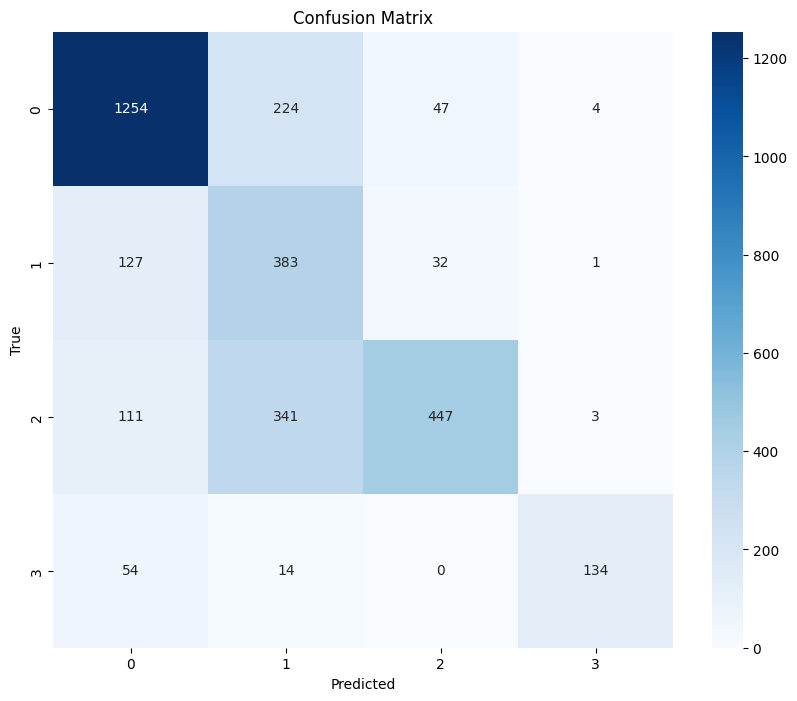

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues") #, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [15]:
print(dense_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,146,702 (34.89 MB)

 Trainable params: 759,108 (2.90 MB)

 Non-trainable params: 6,869,376 (26.20 MB)

 Optimizer params: 1,518,218 (5.79 MB)

None


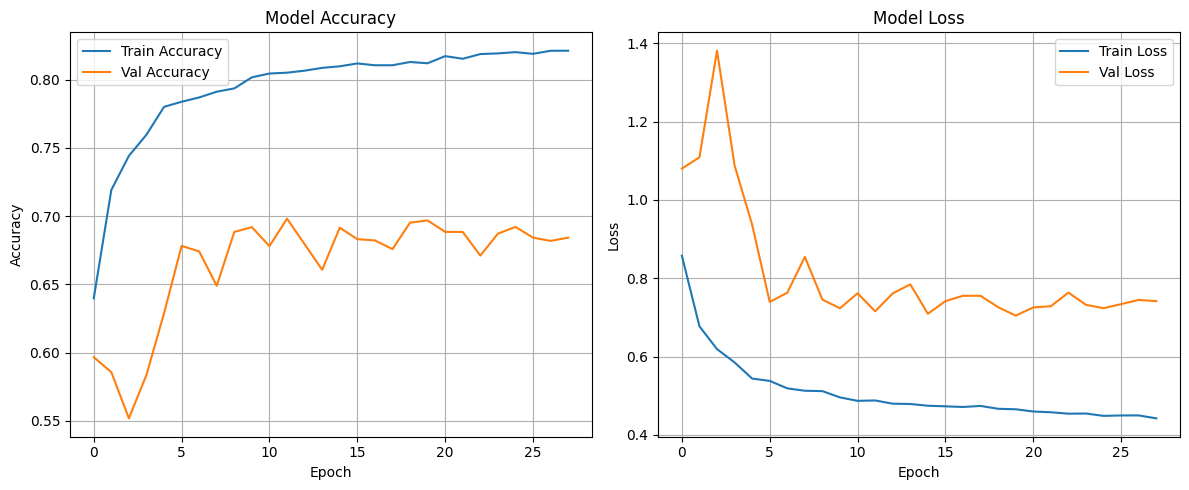

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Train Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
unfrozen_model = load_model('../models/densenet121_model_trainable.keras')

In [8]:
base_model1 = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model1.trainable = False  # freeze weights initially

for layer in base_model1.layers[-10:]:
    layer.trainable = True

inputs = Input(shape=(224, 224, 3))
x = base_model1(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

dense_model1 = Model(inputs=inputs, outputs=outputs)
dense_model1.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
training_history1 = dense_model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, verbose=1, callbacks=[early_stopping, reduce_learning_rate], shuffle=True)

Epoch 1/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 123s 126ms/step - accuracy: 0.6197 - loss: 0.8848 - val_accuracy: 0.7670 - val_loss: 0.5781 - learning_rate: 1.0000e-04
Epoch 2/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.7701 - loss: 0.5524 - val_accuracy: 0.7964 - val_loss: 0.5108 - learning_rate: 1.0000e-04
Epoch 3/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.8034 - loss: 0.4812 - val_accuracy: 0.8175 - val_loss: 0.4540 - learning_rate: 1.0000e-04
Epoch 4/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.8302 - loss: 0.4283 - val_accuracy: 0.8067 - val_loss: 0.5077 - learning_rate: 1.0000e-04
Epoch 5/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.8416 - loss: 0.4070 - val_accuracy: 0.8345 - val_loss: 0.4167 - learning_rate: 1.0000e-04
Epoch 6/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.8545 - loss: 0.3723 - val_accuracy: 0.8314 - val_loss: 0.4453 - learning_rate: 1.0000e-04
Epoch 7/100
683/683 ━━━━━━━━━━━━━━━━━━━━ 34s

In [15]:
dense_model1.save('/content/drive/MyDrive/Colab Notebooks/densenet121_bestest_model.keras')

In [11]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = dense_model1.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=['0', '1', '2', '3'], zero_division=0))

100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 204ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1529
           1       0.73      0.78      0.76       543
           2       0.88      0.76      0.82       902
           3       0.94      0.92      0.93       202

    accuracy                           0.85      3176
   macro avg       0.86      0.85      0.85      3176
weighted avg       0.85      0.85      0.85      3176



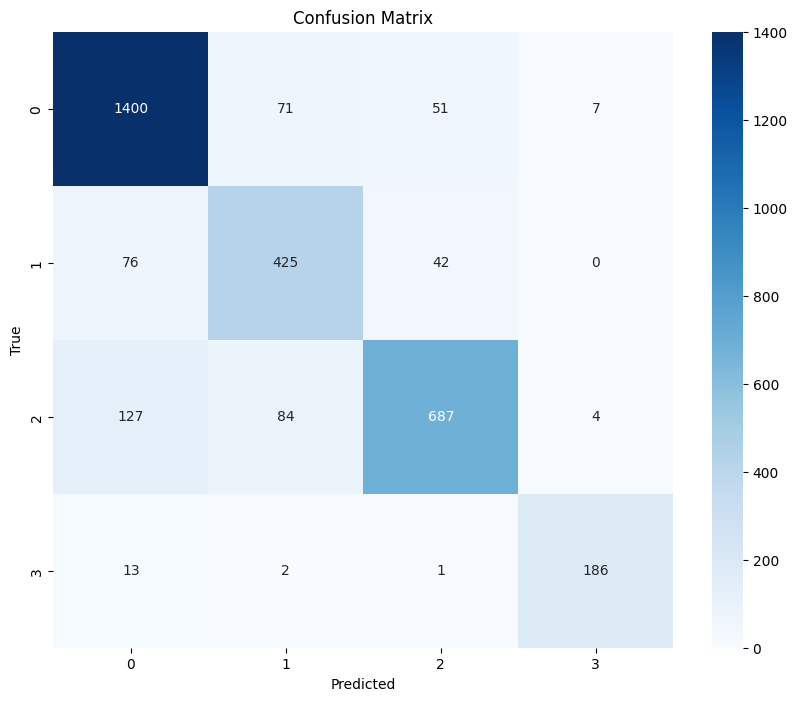

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues") #, xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
from tensorflow.keras.models import load_model
current_model = load_model('/content/drive/MyDrive/Colab Notebooks/densenet121_best_model.keras')

In [18]:
print(current_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,465,870 (39.92 MB)

 Trainable params: 1,418,692 (5.41 MB)

 Non-trainable params: 6,209,792 (23.69 MB)

 Optimizer params: 2,837,386 (10.82 MB)

None


In [5]:
from tensorflow.keras.models import load_model
best_model = load_model('/content/drive/MyDrive/Colab Notebooks/densenet121_bestest_model.keras')

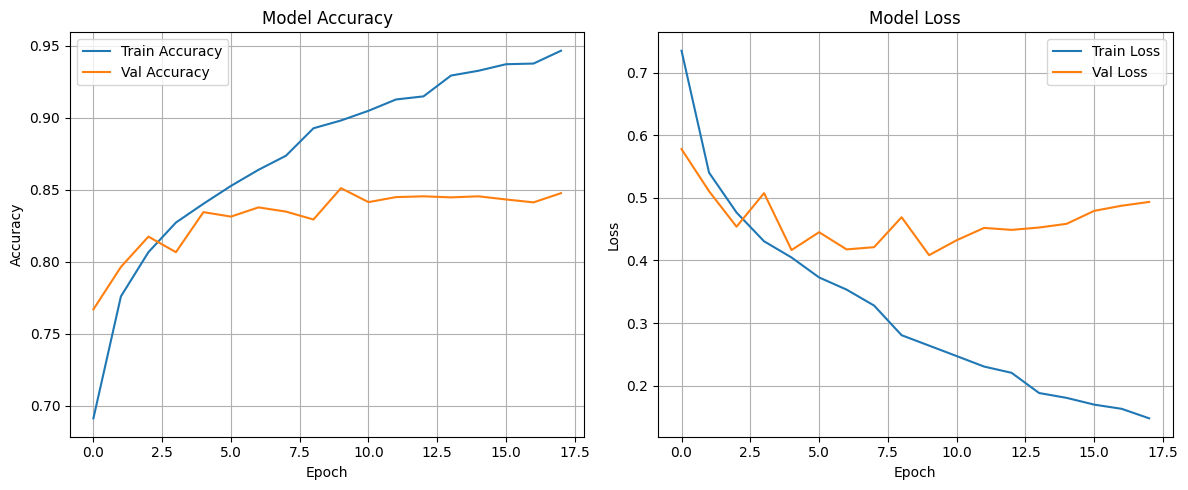

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(training_history1.history['accuracy'], label='Train Accuracy')
plt.plot(training_history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(training_history1.history['loss'], label='Train Loss')
plt.plot(training_history1.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
print(dense_model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,394,814 (35.84 MB)

 Trainable params: 841,812 (3.21 MB)

 Non-trainable params: 6,869,376 (26.20 MB)

 Optimizer params: 1,683,626 (6.42 MB)

None
